https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html

In [4]:
import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [5]:
adata = scvi.data.heart_cell_atlas_subsampled()


INFO     Downloading file at data/hca_subsampled_20k.h5ad                                                          
Downloading...: 100%|██████████| 65714/65714.0 [00:19<00:00, 3421.85it/s]


In [6]:
sc.pp.filter_genes(adata, min_counts=3)

In [7]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [8]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

In [9]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Creating and training a model

In [11]:
model = scvi.model.SCVI(adata)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [12]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [42:05<00:00,  6.23s/it, v_num=1, train_loss_step=260, train_loss_epoch=284]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [42:05<00:00,  6.31s/it, v_num=1, train_loss_step=260, train_loss_epoch=284]


## Saving and loading

In [14]:
model.save("heart_model/")

In [15]:
model = scvi.model.SCVI.load("heart_model/", adata=adata, use_gpu=True)

INFO     File heart_model/model.pt already downloaded                                                              


/home/pranav/mambaforge/lib/python3.10/site-packages/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


RuntimeError: torch.UntypedStorage(): Storage device not recognized: mps

In [16]:
model


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [17]:
latent = model.get_latent_representation()

In [18]:
# store back results into the Anndata format so that scanpy can read it

adata.obsm["X_scVI"] = latent

In [19]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [20]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.496796,0.093885,2.675392,0.002705,5.693960
GAGTCATTCTCCGTGT-1-HCAHeart8287128,1.890682,0.089705,1.463322,0.040904,36.595779
CCTCTGATCGTGACAT-1-HCAHeart7702881,1.244018,0.018150,3.712941,0.018280,2.570224
CGCCATTCATCATCTT-1-H0035_apex,0.388010,0.246542,4.737065,0.006493,7.607854
TCGTAGAGTAGGACTG-1-H0015_septum,0.127262,0.140750,5.835049,0.135836,4.889553


In [21]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

## Interoperability with Scanpy

In [22]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

/home/pranav/mambaforge/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pranav/mambaforge/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pranav/mambaforge/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecatio

/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


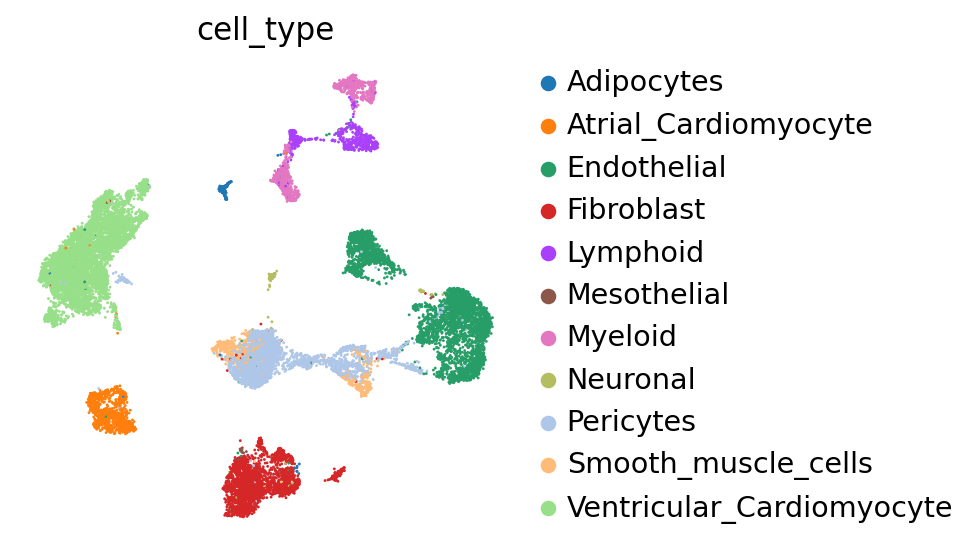

/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


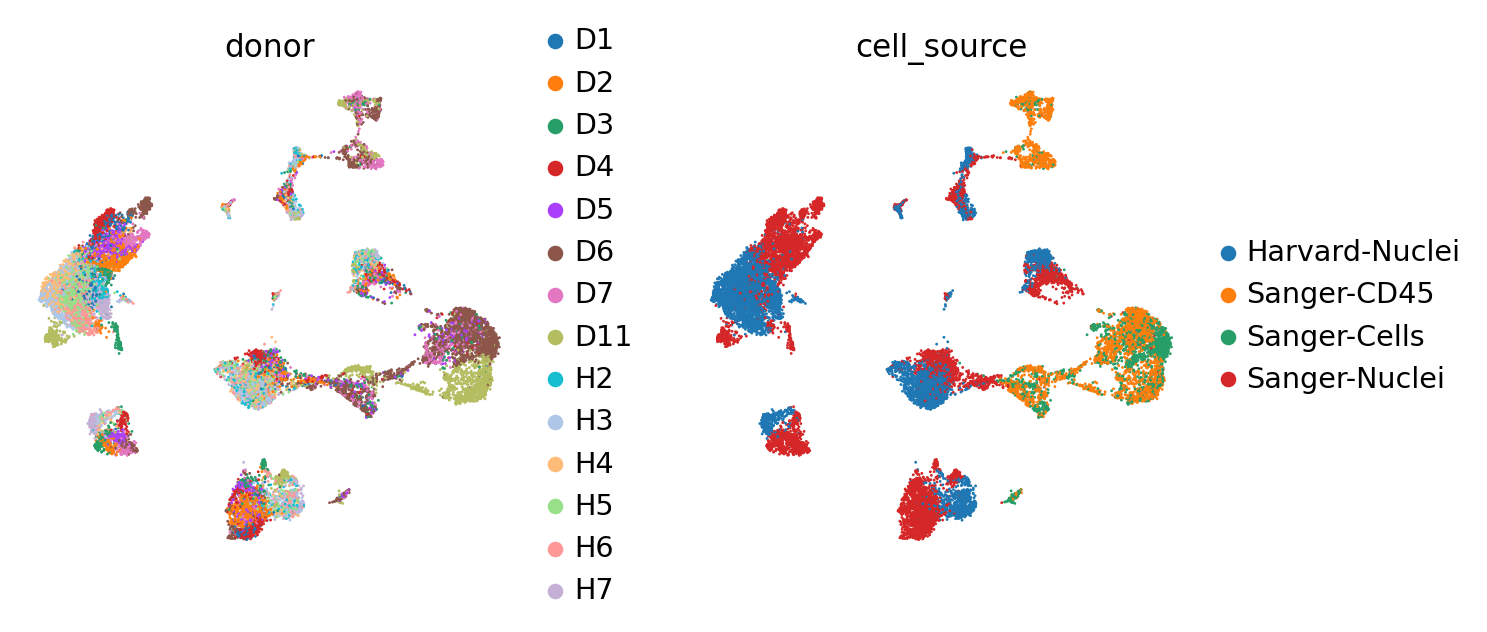

In [23]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

### Visualization of batch correction (scVI)

We now want to account for 'batch effects' in the sc data

In [24]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


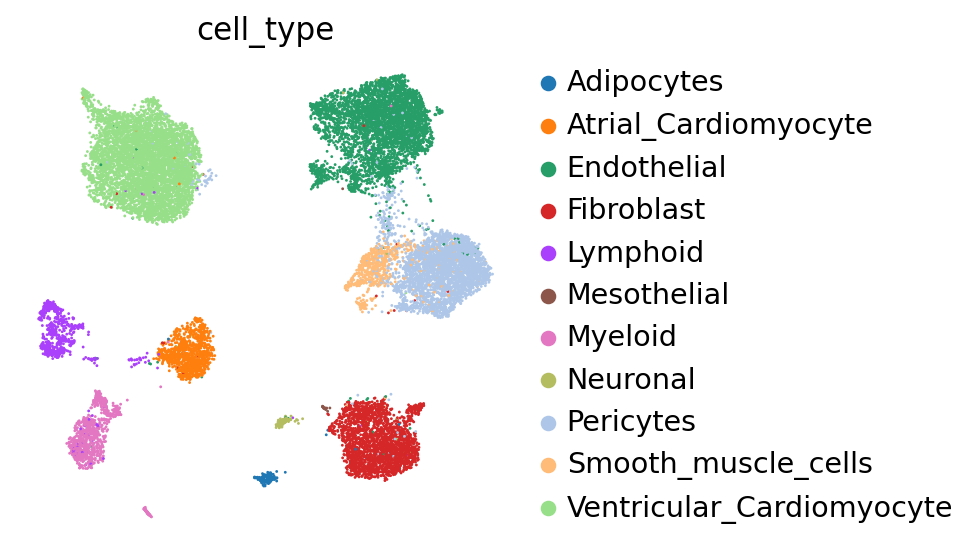

/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


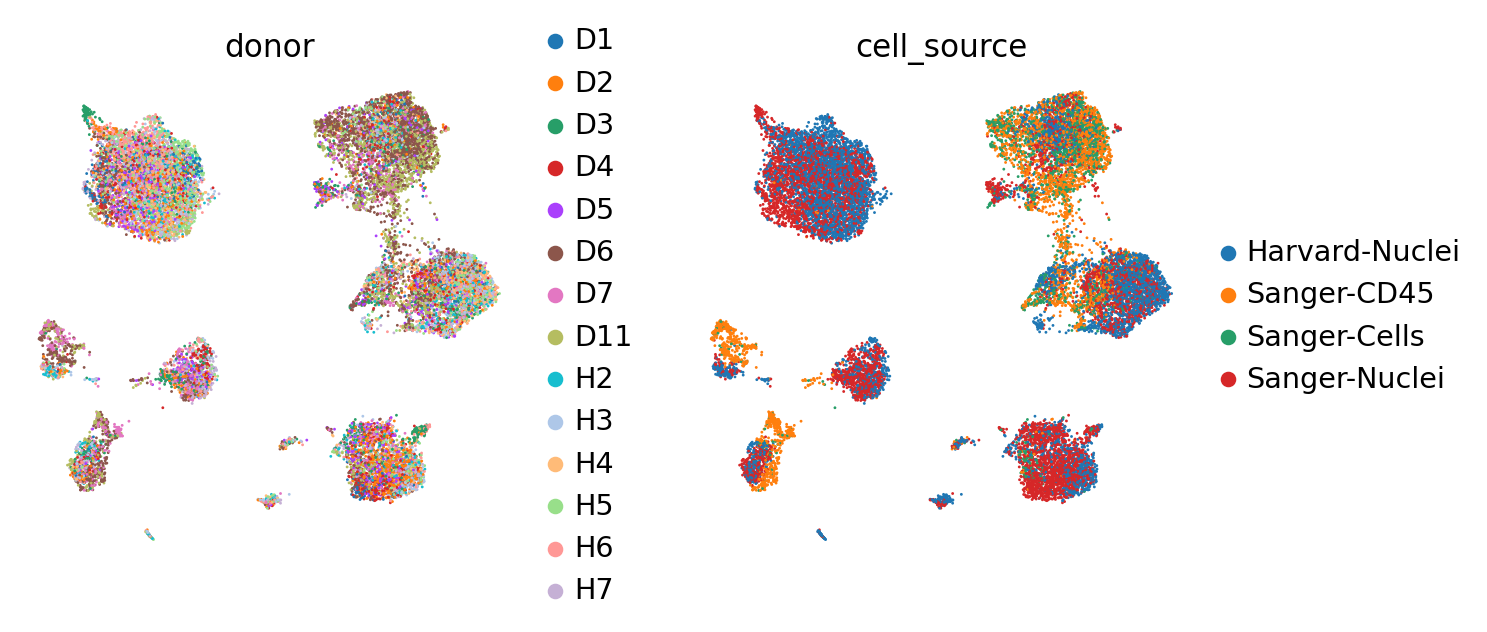

In [25]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)